In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time


# Variables
IMAGE_SIZE = (150,150)
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-4

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale only for validation and test data
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset from folders
dataset_path = "datasets"
classes = ['eggtart', 'salmonsashimi', 'unknown']

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(dataset_path, 'validation'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE

model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(150,150, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        # last dense layer
        Dense(len(classes), activation='softmax')
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Start time
start_time = time.time()

# Train the model
history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    validation_data=validation_generator, 
                    callbacks=[early_stopping, lr_scheduler])

# end Time
end_time = time.time()
# duration 
duration = end_time - start_time

# Save the model
model.save('my_model.h5')


Found 2396 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 299 images belonging to 3 classes.


C:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4929 - loss: 1.5407 - val_accuracy: 0.4967 - val_loss: 1.0101 - learning_rate: 1.0000e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6969 - loss: 0.7439 - val_accuracy: 0.5367 - val_loss: 1.0109 - learning_rate: 1.0000e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7042 - loss: 0.7247 - val_accuracy: 0.4767 - val_loss: 1.0120 - learning_rate: 1.0000e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7475 - loss: 0.6275 - val_accuracy: 0.5067 - val_loss: 1.0362 - learning_rate: 1.0000e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7756 - loss: 0.5707 - val_accuracy: 0.5400 - val_loss: 1.0896 - learning_rate: 1.0000e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8128 - loss: 0.5261 - val_accuracy: 0.6767 - val_loss: 0.8876 - learning_rate: 1.0000e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8189 - loss: 0.4731 - v

Total time taken to train the model: 25 minutes and 1 seconds


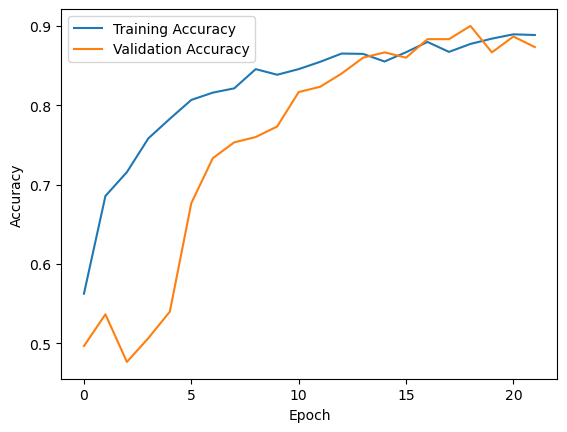

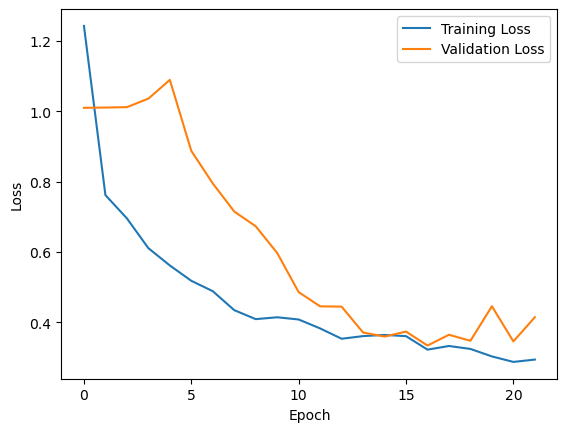

Final Training Accuracy: 0.8886
Final Validation Accuracy: 0.8733
Final Training Loss: 0.2939
Final Validation Loss: 0.4144
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8822 - loss: 0.3259
Test Accuracy: 88.63%
Test Loss: 0.3191


In [2]:
# Convert duration to minutes and seconds
duration_min, duration_sec = divmod(duration, 60)
print(f'Total time taken to train the model: {int(duration_min)} minutes and {int(duration_sec)} seconds')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print out the final accuracy values
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Print out the final loss values
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

In [ ]:
model.summary()